Name: Pranay Jain \
Roll number: AI22BTECH11020

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

## Data Generation

In [26]:
def generate_dataset(num_samples, lower_bound, upper_bound):
  """ Return a list of data samples for the adding problem.

  Parameters
  ----------
  num_samples : int
    The number of data samples to be produced
  lower_bound : int
    Minimum length of any input sequence
  upper_bound : int
    Maximum length of any input sequence

  Returns
  -------
  List<tuple<List<tensor>, tensor>>
    A list consisting of input-label tuples. Each input is a list of 2D tensors and each label is a 1D tensor.
  """

  dataset = []

  for sample in range(num_samples):

    # Select the length of the input sequence randomly in the range [lower_bound, upper_bound]
    input_length = torch.randint(lower_bound, upper_bound + 1, (1,)).item()

    # Select the indices whose second coordinate is 1
    one_indices = random.sample(range(input_length), 2)

    X = []
    for i in range(input_length):
      if i in one_indices: 
        X.append(torch.tensor([torch.rand(1).item(), 1]))
      else:
        X.append(torch.tensor([torch.rand(1).item(), 0]))

    # Compute the true label for the input sequence
    y = sum([X[j][0] for j in one_indices])

    # Reshape y from () to (1,) to match the output shape of the networks
    y = torch.tensor([y.item()])
    dataset.append((X, y))

  return dataset

In [27]:
train_dataset = generate_dataset(5000, 2, 9)
test_dataset = generate_dataset(1000, 2, 20)

# Number of epochs for which the networks will be trained
EPOCHS = 5

The following are some sample inputs (from the problem statement PDF) against which we can test our trained models

In [28]:
sample_input_1 = [
    torch.tensor([1.00, 0]), 
    torch.tensor([0.90, 1]), 
    torch.tensor([0.25, 0]), 
    torch.tensor([0.17, 1]), 
    torch.tensor([0.76, 0])
  ]

sample_input_2 = [
    torch.tensor([0.86, 0]), 
    torch.tensor([0.31, 0]), 
    torch.tensor([0.43, 1]), 
    torch.tensor([0.12, 0]), 
    torch.tensor([0.01, 0]),
    torch.tensor([0.29, 0]),
    torch.tensor([0.95, 0]),
    torch.tensor([0.09, 1]),
  ]

## Elmon RNN

In [29]:
class ElmonRNN:

  def __init__(self, input_dimension=2, hidden_dimension=5, output_dimension=1):

    # Dimensions of the input vector, hidden state and output vector respectively
    self.input_dimension = input_dimension
    self.hidden_dimension = hidden_dimension
    self.output_dimension = output_dimension

    # Parameters of the model
    self.weights_hx = torch.zeros((hidden_dimension, input_dimension), requires_grad=True)
    self.weights_hh = torch.zeros((hidden_dimension, hidden_dimension), requires_grad=True)
    self.bias_h = torch.zeros(hidden_dimension, requires_grad=True)

    self.weights_yh = torch.zeros((output_dimension, hidden_dimension), requires_grad=True)
    self.bias_y = torch.zeros(output_dimension, requires_grad=True)

    # List for storing the training loss at each epoch
    self.loss_per_epoch = []

  def initialize_weights(self):

    # Initialize the parameters randomly
    self.weights_hx = torch.randn(self.hidden_dimension, self.input_dimension, requires_grad=True)
    self.weights_hh = torch.randn(self.hidden_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_h = torch.randn(self.hidden_dimension, requires_grad=True)

    self.weights_yh = torch.randn(self.output_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_y = torch.randn(self.output_dimension, requires_grad=True)

  def forward_pass(self, input_sequence):

    # Perform a sanity check for the input dimensions
    if torch.numel(input_sequence[0]) != self.input_dimension:
      raise ValueError('The dimensions of the input does not match that of the network architecture')

    # Initialize the initial hidden state to the zero vector
    hidden_state = torch.zeros(self.hidden_dimension)

    # The hidden state is propagated forward through the entire input sequence
    for input_vector in input_sequence:
      hidden_state = torch.tanh(self.weights_hx @ input_vector + self.weights_hh @ hidden_state + self.bias_h)

    # Transform the final hidden state to obtain the net output
    output = self.weights_yh @ hidden_state + self.bias_y
    return output

  def train(self, dataset, num_epochs, learning_rate=0.01):

    # Use MSE as the loss function which is optimized using the Adam algorithm
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam([{'params': [
        self.weights_hx, self.weights_hh, self.bias_h, 
        self.weights_yh, self.bias_y]}], 
        lr=learning_rate
      ) 
    self.loss_per_epoch = []
    
    for epoch in range(num_epochs):

      epoch_loss = 0.0

      # Compute and backpropagate the loss for every data sample
      for X, y in dataset:
        optimizer.zero_grad()
        output = self.forward_pass(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

      # Append the average loss at the end of epoch
      self.loss_per_epoch.append(epoch_loss / len(dataset))

  def test(self, dataset):

    total_loss = 0.0
    criterion = torch.nn.MSELoss()

    # Compute loss for every test sample
    for X, y in dataset:
      output = self.forward_pass(X)
      loss = criterion(output, y)
      total_loss += loss.item()

    # Return the average loss over the test dataset
    return total_loss / len(dataset)

Train the Elmon RNN

In [30]:
elmon = ElmonRNN()
elmon.initialize_weights()
elmon.train(train_dataset, EPOCHS)

Plot the training curve

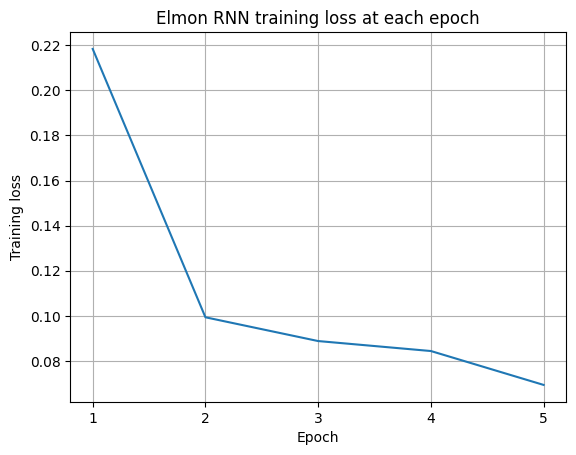

In [31]:
plt.plot(range(1, EPOCHS+1), elmon.loss_per_epoch)
plt.title('Elmon RNN training loss at each epoch')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.xticks(range(1, EPOCHS+1))
plt.grid()

Compute the outputs of the trained model for the above sample inputs

In [32]:
print(elmon.forward_pass(sample_input_1).item())
print(elmon.forward_pass(sample_input_2).item())

1.0681917667388916
0.6243525743484497


Average MSE loss of the trained model on the test dataset

In [33]:
elmon_loss = elmon.test(test_dataset)
elmon_loss

0.05785260709056161

## LSTM

In [34]:
class LSTM:

  def __init__(self, input_dimension=2, hidden_dimension=5, output_dimension=1):

    # Dimensions of the input vector, hidden state and output vector respectively
    self.input_dimension = input_dimension
    self.hidden_dimension = hidden_dimension
    self.output_dimension = output_dimension

    # Parameters of the model
    self.weights_fx = torch.zeros((hidden_dimension, input_dimension), requires_grad=True)
    self.weights_fh = torch.zeros((hidden_dimension, hidden_dimension), requires_grad=True)
    self.bias_f = torch.zeros(hidden_dimension, requires_grad=True)

    self.weights_ix = torch.zeros((hidden_dimension, input_dimension), requires_grad=True)
    self.weights_ih = torch.zeros((hidden_dimension, hidden_dimension), requires_grad=True)
    self.bias_i = torch.zeros(hidden_dimension, requires_grad=True)

    self.weights_cx = torch.zeros((hidden_dimension, input_dimension), requires_grad=True)
    self.weights_ch = torch.zeros((hidden_dimension, hidden_dimension), requires_grad=True)
    self.bias_c = torch.zeros(hidden_dimension, requires_grad=True)

    self.weights_ox = torch.zeros((hidden_dimension, input_dimension), requires_grad=True)
    self.weights_oh = torch.zeros((hidden_dimension, hidden_dimension), requires_grad=True)
    self.bias_o = torch.zeros(hidden_dimension, requires_grad=True)

    self.weights_yh = torch.zeros((output_dimension, hidden_dimension), requires_grad=True)
    self.bias_y = torch.zeros(output_dimension, requires_grad=True)

    # List for storing the training loss at each epoch
    self.loss_per_epoch = []

  def initialize_weights(self):

    # Initialize the parameters randomly
    self.weights_fx = torch.randn(self.hidden_dimension, self.input_dimension, requires_grad=True)
    self.weights_fh = torch.randn(self.hidden_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_f = torch.randn(self.hidden_dimension, requires_grad=True)

    self.weights_ix = torch.randn(self.hidden_dimension, self.input_dimension, requires_grad=True)
    self.weights_ih = torch.randn(self.hidden_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_i = torch.randn(self.hidden_dimension, requires_grad=True)

    self.weights_cx = torch.randn(self.hidden_dimension, self.input_dimension, requires_grad=True)
    self.weights_ch = torch.randn(self.hidden_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_c = torch.randn(self.hidden_dimension, requires_grad=True)

    self.weights_ox = torch.randn(self.hidden_dimension, self.input_dimension, requires_grad=True)
    self.weights_oh = torch.randn(self.hidden_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_o = torch.randn(self.hidden_dimension, requires_grad=True)

    self.weights_yh = torch.randn(self.output_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_y = torch.randn(self.output_dimension, requires_grad=True)

  def forward_pass(self, input_sequence):

    # Perform a sanity check for the input dimensions
    if torch.numel(input_sequence[0]) != self.input_dimension:
      raise ValueError('The dimensions of the input does not match that of the network architecture')

    # Initialize the initial hidden state and cell state to the zero vector
    hidden_state = torch.zeros(self.hidden_dimension)
    cell_state = torch.zeros(self.hidden_dimension)

    # The hidden state and cell state is propagated forward through the entire input sequence
    for input_vector in input_sequence:

      forget_gate = torch.sigmoid(self.weights_fx @ input_vector + self.weights_fh @ hidden_state + self.bias_f)
      input_gate = torch.sigmoid(self.weights_ix @ input_vector + self.weights_ih @ hidden_state + self.bias_i)
      candidate_cell_state = torch.tanh(self.weights_cx @ input_vector + self.weights_ch @ hidden_state + self.bias_c)
      output_gate = torch.sigmoid(self.weights_ox @ input_vector + self.weights_oh @ hidden_state + self.bias_o)

      cell_state = forget_gate * cell_state + input_gate * candidate_cell_state
      hidden_state = output_gate * torch.tanh(cell_state)

    # Transform the final hidden state to obtain the net output
    output = self.weights_yh @ hidden_state + self.bias_y
    return output

  def train(self, dataset, num_epochs, learning_rate=0.01):

    # Use MSE as the loss function which is optimized using the Adam algorithm
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam([{'params': [
        self.weights_fx, self.weights_fh, self.bias_f,
        self.weights_ix, self.weights_ih, self.bias_i,
        self.weights_cx, self.weights_ch, self.bias_c,
        self.weights_ox, self.weights_oh, self.bias_o, 
        self.weights_yh, self.bias_y]}], 
        lr=learning_rate
      ) 
    self.loss_per_epoch = []
    
    for epoch in range(num_epochs):

      epoch_loss = 0.0

      # Compute and backpropagate the loss for every data sample
      for X, y in dataset:
        optimizer.zero_grad()
        output = self.forward_pass(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

      # Append the average loss at the end of epoch
      self.loss_per_epoch.append(epoch_loss / len(dataset))

  def test(self, dataset):

    total_loss = 0.0
    criterion = torch.nn.MSELoss()

    # Compute loss for every test sample
    for X, y in dataset:
      output = self.forward_pass(X)
      loss = criterion(output, y)
      total_loss += loss.item()

    # Return the average loss over the test dataset
    return total_loss / len(dataset)

Train the LSTM

In [35]:
lstm = LSTM()
lstm.initialize_weights()
lstm.train(train_dataset, EPOCHS)

Plot the training curve

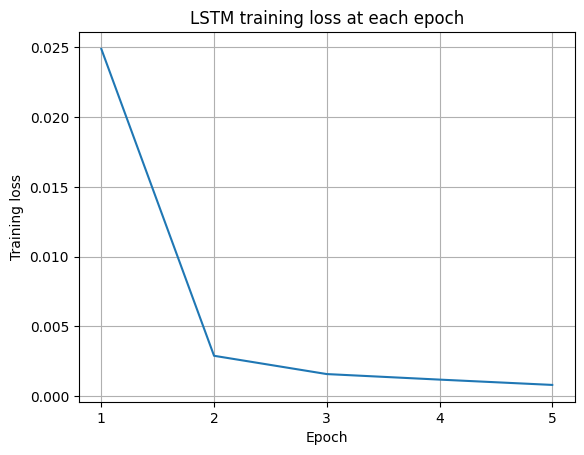

In [36]:
plt.plot(range(1, EPOCHS+1), lstm.loss_per_epoch)
plt.title('LSTM training loss at each epoch')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.xticks(range(1, EPOCHS+1))
plt.grid()

Compute the outputs of the trained model for the above sample inputs

In [37]:
print(lstm.forward_pass(sample_input_1).item())
print(lstm.forward_pass(sample_input_2).item())

1.08525550365448
0.4909403920173645


Average MSE loss of the trained model on the test dataset

In [38]:
lstm_loss = lstm.test(test_dataset)
lstm_loss

0.0004875972130450492

## GRU

In [39]:
class GRU:

  def __init__(self, input_dimension=2, hidden_dimension=5, output_dimension=1):

    # Dimensions of the input vector, hidden state and output vector respectively
    self.input_dimension = input_dimension
    self.hidden_dimension = hidden_dimension
    self.output_dimension = output_dimension

    # Parameters of the model
    self.weights_zx = torch.zeros((hidden_dimension, input_dimension), requires_grad=True)
    self.weights_zh = torch.zeros((hidden_dimension, hidden_dimension), requires_grad=True)
    self.bias_z = torch.zeros(hidden_dimension, requires_grad=True)

    self.weights_rx = torch.zeros((hidden_dimension, input_dimension), requires_grad=True)
    self.weights_rh = torch.zeros((hidden_dimension, hidden_dimension), requires_grad=True)
    self.bias_r = torch.zeros(hidden_dimension, requires_grad=True)

    self.weights_hx = torch.zeros((hidden_dimension, input_dimension), requires_grad=True)
    self.weights_hh = torch.zeros((hidden_dimension, hidden_dimension), requires_grad=True)
    self.bias_h = torch.zeros(hidden_dimension, requires_grad=True)

    self.weights_yh = torch.zeros((output_dimension, hidden_dimension), requires_grad=True)
    self.bias_y = torch.zeros(output_dimension, requires_grad=True)

    # List for storing the training loss at each epoch
    self.loss_per_epoch = []

  def initialize_weights(self):

    # Initialize the parameters randomly
    self.weights_zx = torch.randn(self.hidden_dimension, self.input_dimension, requires_grad=True)
    self.weights_zh = torch.randn(self.hidden_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_z = torch.randn(self.hidden_dimension, requires_grad=True)

    self.weights_rx = torch.randn(self.hidden_dimension, self.input_dimension, requires_grad=True)
    self.weights_rh = torch.randn(self.hidden_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_r = torch.randn(self.hidden_dimension, requires_grad=True)

    self.weights_hx = torch.randn(self.hidden_dimension, self.input_dimension, requires_grad=True)
    self.weights_hh = torch.randn(self.hidden_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_h = torch.randn(self.hidden_dimension, requires_grad=True)

    self.weights_yh = torch.randn(self.output_dimension, self.hidden_dimension, requires_grad=True)
    self.bias_y = torch.randn(self.output_dimension, requires_grad=True)

  def forward_pass(self, input_sequence):

    # Perform a sanity check for the input dimensions
    if torch.numel(input_sequence[0]) != self.input_dimension:
      raise ValueError('The dimensions of the input does not match that of the network architecture')

    # Initialize the initial hidden state to the zero vector
    hidden_state = torch.zeros(self.hidden_dimension)

    # The hidden state is propagated forward through the entire input sequence
    for input_vector in input_sequence:

      update_gate = torch.sigmoid(self.weights_zx @ input_vector + self.weights_zh @ hidden_state + self.bias_z)
      reset_gate = torch.sigmoid(self.weights_rx @ input_vector + self.weights_rh @ hidden_state + self.bias_r)
      candidate_hidden_state = torch.tanh(self.weights_hx @ input_vector + self.weights_hh @ (reset_gate * hidden_state) + self.bias_h)

      hidden_state = (1 - update_gate) * hidden_state + update_gate * candidate_hidden_state

    # Transform the final hidden state to obtain the net output
    output = self.weights_yh @ hidden_state + self.bias_y
    return output

  def train(self, dataset, num_epochs, learning_rate=0.01):

    # Use MSE as the loss function which is optimized using the Adam algorithm
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam([{'params': [
        self.weights_zx, self.weights_zh, self.bias_z,
        self.weights_rx, self.weights_rh, self.bias_r,
        self.weights_hx, self.weights_hh, self.bias_h,
        self.weights_yh, self.bias_y]}], 
        lr=learning_rate
      ) 
    self.loss_per_epoch = []
    
    for epoch in range(num_epochs):

      epoch_loss = 0.0

      # Compute and backpropagate the loss for every data sample
      for X, y in dataset:
        optimizer.zero_grad()
        output = self.forward_pass(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

      # Append the average loss at the end of epoch
      self.loss_per_epoch.append(epoch_loss / len(dataset))

  def test(self, dataset):

    total_loss = 0.0
    criterion = torch.nn.MSELoss()

    # Compute loss for every test sample
    for X, y in dataset:
      output = self.forward_pass(X)
      loss = criterion(output, y)
      total_loss += loss.item()

    # Return the average loss over the test dataset
    return total_loss / len(dataset)

Train the GRU

In [40]:
gru = GRU()
gru.initialize_weights()
gru.train(train_dataset, EPOCHS)

Plot the training curve

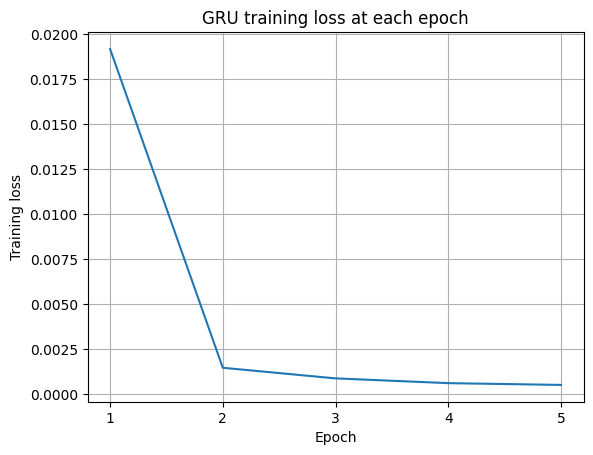

In [41]:
plt.plot(range(1, EPOCHS+1), gru.loss_per_epoch)
plt.title('GRU training loss at each epoch')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.xticks(range(1, EPOCHS+1))
plt.grid()

Compute the outputs of the trained model for the above sample inputs

In [42]:
print(gru.forward_pass(sample_input_1).item())
print(gru.forward_pass(sample_input_2).item())

1.0641690492630005
0.513192355632782


Average MSE loss of the trained model on the test dataset

In [43]:
gru_loss = gru.test(test_dataset)
gru_loss

0.0003730692853482793

## Baseline

In [44]:
class Baseline:

  def __init__(self, prediction=1.0):

    # The constant prediction that the baseline is going to make
    self.prediction = prediction

  def forward_pass(self, input_sequence):

    # Return a tensor of the (fixed) prediction
    return torch.tensor([self.prediction])

  def test(self, dataset):

    total_loss = 0.0
    criterion = torch.nn.MSELoss()

    # Compute loss for every test sample
    for X, y in dataset:
      output = self.forward_pass(X)
      loss = criterion(output, y)
      total_loss += loss.item()

    # Return the average loss over the test dataset
    return total_loss / len(dataset)

Average MSE loss of the baseline on the test dataset

In [45]:
baseline = Baseline(1.0)
baseline_loss = baseline.test(test_dataset)
baseline_loss

0.17104517909246808

## Comparison of models

Comparison of training loss

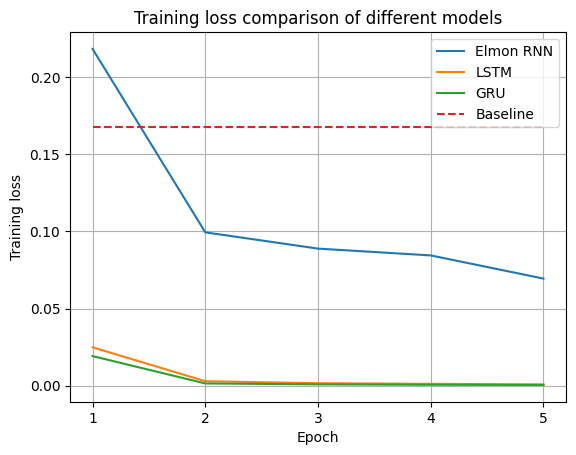

In [46]:
baseline_training_loss = baseline.test(train_dataset)

plt.plot(range(1, EPOCHS+1), elmon.loss_per_epoch, label='Elmon RNN')
plt.plot(range(1, EPOCHS+1), lstm.loss_per_epoch, label='LSTM')
plt.plot(range(1, EPOCHS+1), gru.loss_per_epoch, label='GRU')
plt.plot(range(1, EPOCHS+1), [baseline_training_loss] * EPOCHS, '--', label='Baseline')

plt.title('Training loss comparison of different models')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.xticks(range(1, EPOCHS+1))
plt.legend()
plt.grid()

Comparison of testing loss (final performance)

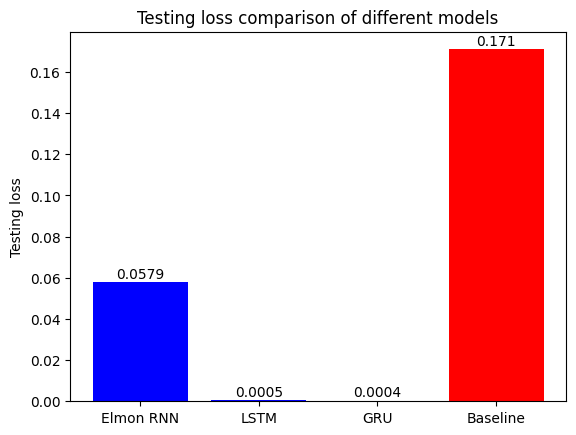

In [47]:
model_list = ['Elmon RNN', 'LSTM', 'GRU', 'Baseline']
loss_list = [elmon_loss, lstm_loss, gru_loss, baseline_loss]

plt.bar(model_list, loss_list, color=['blue', 'blue', 'blue', 'red'])
plt.title('Testing loss comparison of different models')
plt.ylabel('Testing loss')

# Display the loss value above the respective bar
for index, value in enumerate(loss_list):
  plt.text(index, value + 0.002, str(round(value, 4)), ha='center')

Since the testing losses of LSTM and GRU are very small, let us plot the losses on the logarithmic scale for better visualization

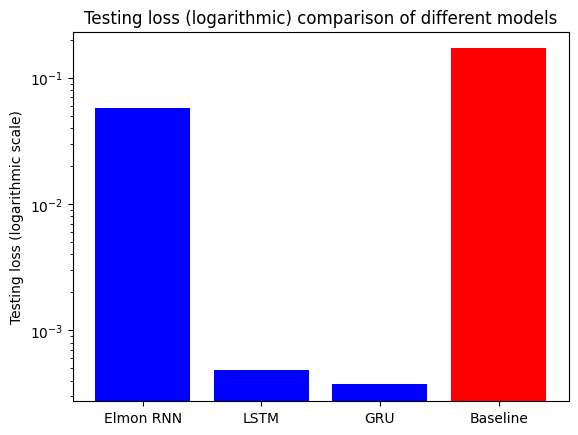

In [48]:
plt.bar(model_list, loss_list, color=['blue', 'blue', 'blue', 'red'])
plt.title('Testing loss (logarithmic) comparison of different models')
plt.ylabel('Testing loss (logarithmic scale)')
plt.yscale('log')